# Predicting Bike Sharing using a Neural Network

Here we try to build a simple multi-layer-perceptron (MLP) or a Neural Network (NN) from scratch just using numpy.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Explore and Prepare Data

In [2]:
data_path = 'data/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


`cnt` column above shows total numbers of riders i.e. `casual` + `registered`

In [4]:
rides.shape

(17379, 17)

<AxesSubplot:xlabel='dteday'>

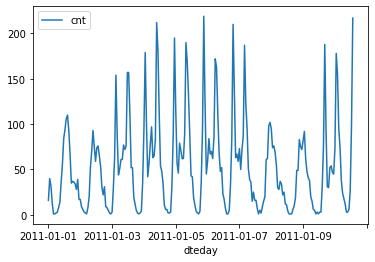

In [5]:
rides[:24*10].plot(x='dteday', y='cnt')

The plot above shows the number of bike riders over the first 10 days or so in the. Hourly rentals are seen here. Its evident from the plot that ridership fluctuates a lot between days of the week. `weekend`, `workingday`, `temperature`, `humidity`, and `windspeed` are likely affecting the number of riders. Our model should capture the relationship between these attributes.

### Encode data
One hot encode categorical variables

In [6]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scale data
To make training the network efficient, standardize each of the continuous variables. 

In [7]:
# Save the data for approximately the last 21 days as test dataset
test_data = data[-21*24:]

# Now remove the test dataset from the original dataset 
data = data[:-21*24]

# Scale the continuous features
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    
    # Store the statistics, to be used on test data during evaluation
    scaled_features[each] = [mean, std]
    
    data.loc[:, each] = (data[each] - mean)/std
    test_data.loc[:, each] = (test_data[each] - mean)/std

### Split data 
Further split data into training and validation sets

Approximately 21 days of data is already held out as test set (above cell), the test set will be used evaluate the trained model by making predictions and compare them with the actual number of riders.
Hold out the last 60 days of data as a validation set, remaining data will be used as training set

In [8]:
# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [9]:
# train and validation set split
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Implement the Neural Network

A network (shown below) with one hidden layer will be implemented. The output layer has only one node and is used for the regression.

<img src="images/network.png" width=300px>

* The hidden layer will use a `sigmoid` activation. No activation to be used in output layer because its a regression problem.
* Mean Squared Error (`MSE`) is used as the loss function
* In forward pass weights are used to propagate signals forward from the input to the output layers in the neural network. 
* In backward pass (backpropagation) weights are used again to propagate error/loss backwards from the output back into the network to update network weights. 
* The network-weights are initalized with randomly drawn float from a `normal` distribution having range from $0.0$ to $\sqrt{number\_of\_nodes}$

In [10]:
# The neural network class

class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))
        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        # Define activation_function as a 'sigmoid'
        self.activation_function = lambda x : 1/(1 + np.exp(-x))  
                    

    def train(self, features, targets):
        ''' Train the network on batch of data-points. 
        
            Arguments
            ---------
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        '''
        n_records = features.shape[0]
        # Zero initialize the respective delta-weight-update matrices with same shape as that of input and hidden layers weight matrices
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        
        # Pass each data-point (record) through the network and backpropogate the error obtained
        for X, y in zip(features, targets):   
            # Forward-pass
            final_outputs, hidden_outputs = self.forward_pass_train(X)  
            
            # Backward-pass - keeps updating delta-weights once for each record
            delta_weights_i_h, delta_weights_h_o = self.backpropagation(final_outputs, hidden_outputs, X, y, 
                                                                        delta_weights_i_h, delta_weights_h_o)
            
        # Once all data-points in the batch are processed (i.e. one epoch done) then update network's 
        # input and hidden weights with delta-weight computed above
        self.update_weights(delta_weights_i_h, delta_weights_h_o, n_records)

        
    def forward_pass_train(self, X):
        ''' Push the data-point forward through the network
         
            Arguments
            ---------
            X: features batch
        '''
        # Signals into hidden layer 
        hidden_inputs = np.dot(X, self.weights_input_to_hidden) 
        # Signals from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)      
              
        # signals into final output layer
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) 
        # signals from final output layer
        final_outputs = final_inputs                                         
        
        return final_outputs, hidden_outputs

    
    def backpropagation(self, final_outputs, hidden_outputs, X, y, delta_weights_i_h, delta_weights_h_o):
        ''' Push the loss/error backward through the network using gradient descend
         
            Arguments
            ---------
            final_outputs: output from forward pass
            y: target (i.e. label) batch
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers
        '''
        # Compute final-output-error
        # which is the difference between desired target and actual output.
        error =  y - final_outputs  
        
        # Using the final-output-error and final layer output derivative function compute the final-output-error-term 
        # Note that output layer output is just y=x hence its slope(derivative) is 1
        output_error_term = error * (1) 
        
        # Compute delta-weight for weights between hidden and output layer 
        # as the fraction proportional to final-output-error-term and hidden-outputs 
        delta_weights_h_o += output_error_term * hidden_outputs[:, None]
        
        

        # Compute the hidden-layer-error-contribution in the final-output-error-trem
        # which is a fraction proportional to respective weights between hidden and output layer
        hidden_error = np.dot(output_error_term, self.weights_hidden_to_output.T)
        
        # Using the hidden-layer-error-contribution and hidden layer output derivative function 
        # compute the hidden-output-error-term 
        # Note that hidden layer uses `sigmoid` activation function hence its slope(derivative) is
        # x * (1 - x) where x is hidden layer output
        hidden_error_term = hidden_error * (hidden_outputs * (1 - hidden_outputs))
        
        # Compute delta-weight for weights between input and hidden layer 
        # as the fraction proportional to hidden-layer-error-contribution and input signals 
        delta_weights_i_h += hidden_error_term * X[:, None]
        
      
        return delta_weights_i_h, delta_weights_h_o
    
    
    def update_weights(self, delta_weights_i_h, delta_weights_h_o, n_records):
        ''' Update weights on gradient descent step
         
            Arguments
            ---------
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers
            n_records: number of records
        '''
        # update hidden-to-output weights with gradient descent step
        self.weights_hidden_to_output += self.lr * (delta_weights_h_o/n_records) 
        
        # update input-to-hidden weights with gradient descent step
        self.weights_input_to_hidden += self.lr * (delta_weights_i_h/n_records)  

        
    def run(self, features):
        ''' Runs a batch of data-points forward pass through the network 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        # Signals into hidden layer
        hidden_inputs = np.dot(features, self.weights_input_to_hidden) 
        
        # Signals out from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)       
        
        # Signals into final output layer
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) 
        
        # Signals out from final output layer
        final_outputs = final_inputs                                         
        
        return final_outputs

### Implement loss function

In [11]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Train the network

We'll choose a set of hyperparameters for the network through experimentation. Need to find hyperparameters such that the error on the training is low, but we are not overfitting. 
Overfitting can be easily identified by looking at the plot below if training loss keeps going down but validation loss starts increasing.

In [12]:
# Experiment with different values of hyperparameters and then choose optimal values
iterations = 5000
learning_rate = 0.5
hidden_nodes = 25
output_nodes = 1

# Create the network using the hyperparameters chosen above
N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

# Train the network for iterations chosen
losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['cnt']

    network.train(X, y)

    # Predict and compute loss using the so far training model on training and validation sets
    train_loss = MSE(np.array(network.run(train_features)).T, train_targets['cnt'].values)
    val_loss = MSE(np.array(network.run(val_features)).T, val_targets['cnt'].values)
    
    # Display the current training and validation loss
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()

    # Save train and val losses for each iteration 
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 0.067 ... Validation loss: 0.149

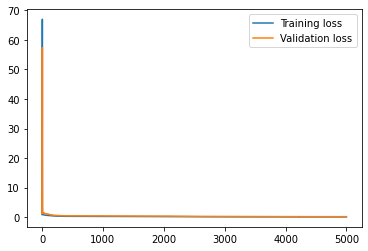

In [13]:
# Plot losses
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Evaluate the network

Here, we use the separately kept test data to view how well your network is modeling the data.

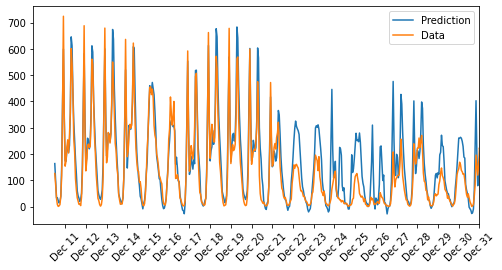

In [14]:
fig, ax = plt.subplots(figsize=(8,4))

# Scale the test data using the train statistics computed earlier
# and then use test data to make predictions 
mean, std = scaled_features['cnt']
predictions = np.array(network.run(test_features)).T*std + mean

# Plot predicted count along with actual count
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()
dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

Its clearly seen in the plot above that network has modeled the data very well, We see that prediction (blue-line) is mimicking the actual targets (orange-line) for most of the periods. However, it appears that prediction seems to be inaccurate from Dec 22 till Dec 31. This is the Xmas holiday period and during this period people may not ride bike as much as they do during non-holiday season. 
Since we have only 2 years worth of data (i.e. two Xmas seasons) there is not enough data for our model to detect this anomaly, hence predictions are not accurate for holiday period.